In [17]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [18]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [19]:
# Specify data URI
URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [22]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │          1,152 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         16,512 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y1_output (Dense)         │ (None, 1)              │            129 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y2_output (Dense)         │ (None, 1)              │             65 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [25]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 524.9562 - y1_output_loss: 260.9961 - y1_output_root_mean_squared_error: 15.4160 - y2_output_loss: 263.9281 - y2_output_root_mean_squared_error: 15.4271 - val_loss: 62.5409 - val_y1_output_loss: 19.9215 - val_y1_output_root_mean_squared_error: 4.3707 - val_y2_output_loss: 44.3947 - val_y2_output_root_mean_squared_error: 6.5908
Epoch 2/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 38.0757 - y1_output_loss: 14.7128 - y1_output_root_mean_squared_error: 3.8181 - y2_output_loss: 23.3552 - y2_output_root_mean_squared_error: 4.8230 - val_loss: 44.3905 - val_y1_output_loss: 18.0118 - val_y1_output_root_mean_squared_error: 4.1787 - val_y2_output_loss: 26.5584 - val_y2_output_root_mean_squared_error: 5.1893
Epoch 3/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 27.4558 - y1_output_loss: 9.8922 - y1_output_root_mean_squared_error: 3.1329 - y2_output_loss: 17.5583 - y2_output_root_mean_squared_error: 4.1743 - val_loss: 55.0308 -

In [26]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0826 - y1_output_loss: 0.1937 - y1_output_root_mean_squared_error: 0.4396 - y2_output_loss: 0.8830 - y2_output_root_mean_squared_error: 0.9405
Loss = 0.9729774594306946, Y1_loss = 0.17712661623954773, Y1_mse = 0.42082399129867554, Y2_loss = 0.7783629894256592, Y2_mse = 0.8921236395835876


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


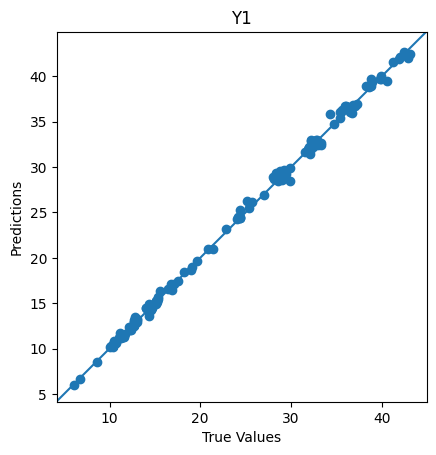

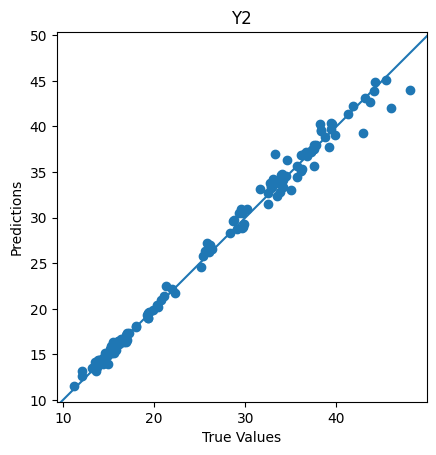

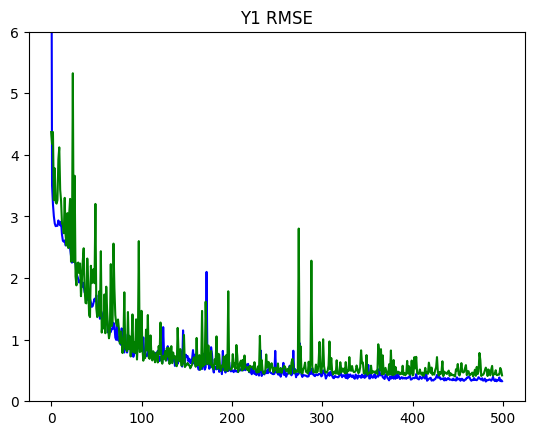

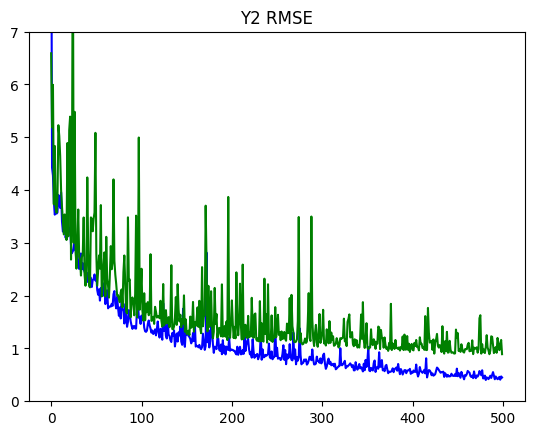

In [27]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)